In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Categories: ['COVID', 'COVID.metadata.xlsx', 'Lung_Opacity', 'Lung_Opacity.metadata.xlsx', 'Normal', 'Normal.metadata.xlsx', 'README.md.txt', 'Viral Pneumonia', 'Viral Pneumonia.metadata.xlsx']
Number of images in COVID: 3616
Number of images in Lung_Opacity: 6012
Number of images in Normal: 10192
Number of images in Viral Pneumonia: 1345


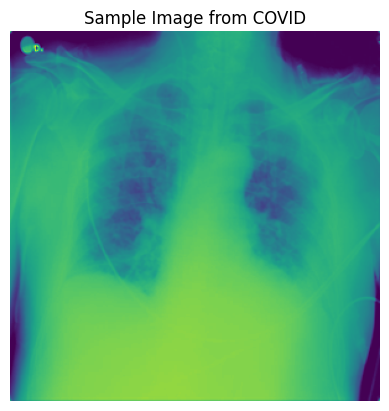

In [2]:
# Define the base directory
data_dir = r'C:\Users\SHRAVYA\Downloads\archive (12)\COVID-19_Radiography_Dataset'

# List categories (folders) in the dataset directory
categories = os.listdir(data_dir)
print(f"Categories: {categories}")

# Iterate over each category to count images in the 'images' subfolder
for category in categories:
    category_path = os.path.join(data_dir, category)
    
    # Check if it is a directory (skip metadata files)
    if os.path.isdir(category_path):
        images_path = os.path.join(category_path, 'images')
        if os.path.exists(images_path):
            # Count the number of images in the 'images' folder
            num_images = len(os.listdir(images_path))
            print(f"Number of images in {category}: {num_images}")
        else:
            print(f"No 'images' folder found in {category}")

# Display a sample image from the first category
sample_category = categories[0]  # Choose the first category for the sample
sample_image_folder = os.path.join(data_dir, sample_category, 'images')

# Make sure there are images in the folder
if os.path.exists(sample_image_folder) and os.listdir(sample_image_folder):
    sample_image_path = os.path.join(sample_image_folder, os.listdir(sample_image_folder)[0])
    
    # Load and display the sample image
    img = Image.open(sample_image_path)
    plt.imshow(img)
    plt.title(f"Sample Image from {sample_category}")
    plt.axis('off')
    plt.show()
else:
    print(f"No images found in the 'images' folder of {sample_category}")


In [3]:
base_split_dir = r'C:\Users\SHRAVYA\Downloads\archive (12)\COVID-19_Radiography_Dataset_Split'
train_dir = os.path.join(base_split_dir, 'train')
val_dir = os.path.join(base_split_dir, 'validation')
test_dir = os.path.join(base_split_dir, 'test')

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to split and copy images
def split_and_copy_images(category, source_folder, train_split=0.7, val_split=0.15, test_split=0.15):
    images_path = os.path.join(data_dir, category, 'images')
    
    # Get all images in the category's 'images' folder
    if os.path.exists(images_path):
        all_images = os.listdir(images_path)
        
        # Randomly shuffle the images
        random.shuffle(all_images)
        
        # Split the dataset into train, validation, and test sets
        train_images, temp_images = train_test_split(all_images, train_size=train_split, random_state=42)
        val_images, test_images = train_test_split(temp_images, test_size=test_split / (val_split + test_split), random_state=42)
        
        # Helper function to copy images to the target directory
        def copy_images(image_list, dest_dir):
            os.makedirs(dest_dir, exist_ok=True)
            for img in image_list:
                src_path = os.path.join(images_path, img)
                dst_path = os.path.join(dest_dir, img)
                shutil.copy(src_path, dst_path)
        
        # Copy images to the respective directories
        copy_images(train_images, os.path.join(train_dir, category))
        copy_images(val_images, os.path.join(val_dir, category))
        copy_images(test_images, os.path.join(test_dir, category))
        
        print(f"Completed splitting for {category}:")
        print(f"  Train: {len(train_images)} images")
        print(f"  Validation: {len(val_images)} images")
        print(f"  Test: {len(test_images)} images")

# Iterate over each category and perform splitting
for category in categories:
    category_path = os.path.join(data_dir, category)
    
    if os.path.isdir(category_path):
        # Split images for the current category
        split_and_copy_images(category, category_path)

print("Data splitting completed!")

Completed splitting for COVID:
  Train: 2531 images
  Validation: 542 images
  Test: 543 images
Completed splitting for Lung_Opacity:
  Train: 4208 images
  Validation: 902 images
  Test: 902 images
Completed splitting for Normal:
  Train: 7134 images
  Validation: 1529 images
  Test: 1529 images
Completed splitting for Viral Pneumonia:
  Train: 941 images
  Validation: 202 images
  Test: 202 images
Data splitting completed!


Found 42330 images belonging to 4 classes.


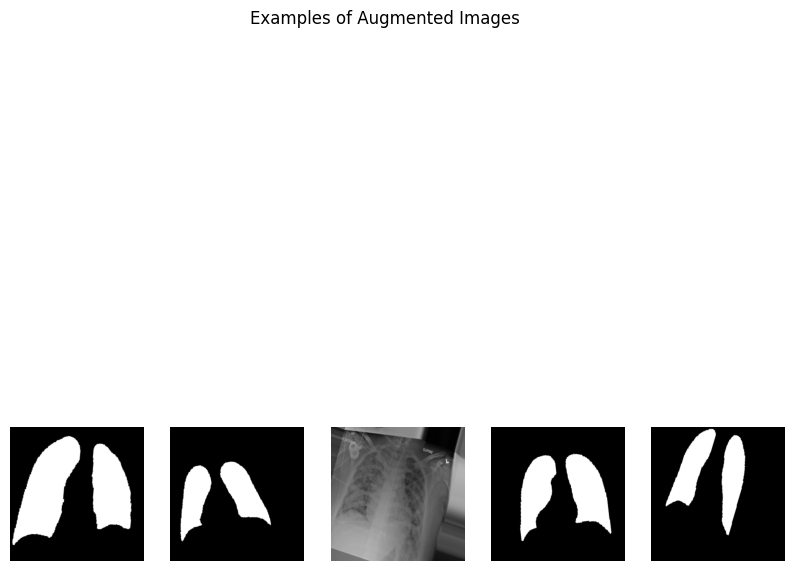

In [4]:
# Define the paths to the images folder in each category
covid_images_path = os.path.join(data_dir, 'covid', 'images')
lung_opacity_images_path = os.path.join(data_dir, 'lung_opacity', 'images')
normal_images_path = os.path.join(data_dir, 'normal', 'images')
viral_pneumonia_images_path = os.path.join(data_dir, 'viral_pneumonia', 'images')

# Create an ImageDataGenerator for data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=20,           # Randomly rotate images by up to 20 degrees
    width_shift_range=0.1,       # Randomly translate images horizontally by up to 10%
    height_shift_range=0.1,      # Randomly translate images vertically by up to 10%
    shear_range=0.2,             # Shear the images randomly
    zoom_range=0.2,              # Randomly zoom in or out
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Fill any missing pixels with the nearest value
)

# Example of using data augmentation on a directory of images
batch_size = 32
img_size = (300, 300)  # Target image size for resizing

# Generate augmented images from the dataset
train_generator = data_augmentation.flow_from_directory(
    directory=data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    subset='training'
)

# Display a few augmented images as examples
x_batch, y_batch = next(train_generator)

# Plot the first 5 augmented images
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_batch[i].astype('uint8'))  # Convert image data to uint8 format for visualization
    plt.axis('off')
plt.suptitle('Examples of Augmented Images')
plt.show()

Found 42330 images belonging to 4 classes.


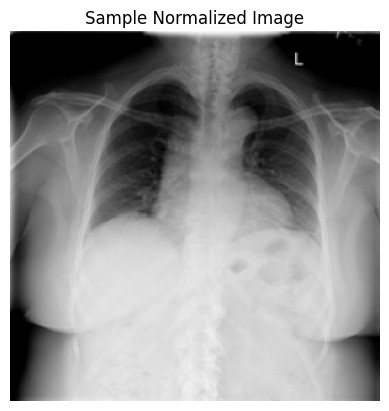

In [5]:
# Define image dimensions
img_height, img_width = 300, 300

# Create ImageDataGenerator for normalization and rescaling
data_gen = ImageDataGenerator(
    rescale=1.0/255.0  # Rescale pixel values to be between 0 and 1
)

# Define the path to the dataset
images_dir = os.path.join(data_dir, sample_category, 'images')

# Generate a normalized dataset from the images directory
normalized_data = data_gen.flow_from_directory(
    directory=data_dir,
    target_size=(img_height, img_width),  # Resize images to a consistent size
    batch_size=32,
    class_mode='binary',  # Set to 'binary' or 'categorical' depending on the labels
    subset=None
)

# Display a sample normalized image
sample_batch = next(normalized_data)
normalized_img = sample_batch[0][0]  # Take the first image from the first batch

# Display the normalized image
plt.imshow(normalized_img)
plt.title("Sample Normalized Image")
plt.axis('off')
plt.show()

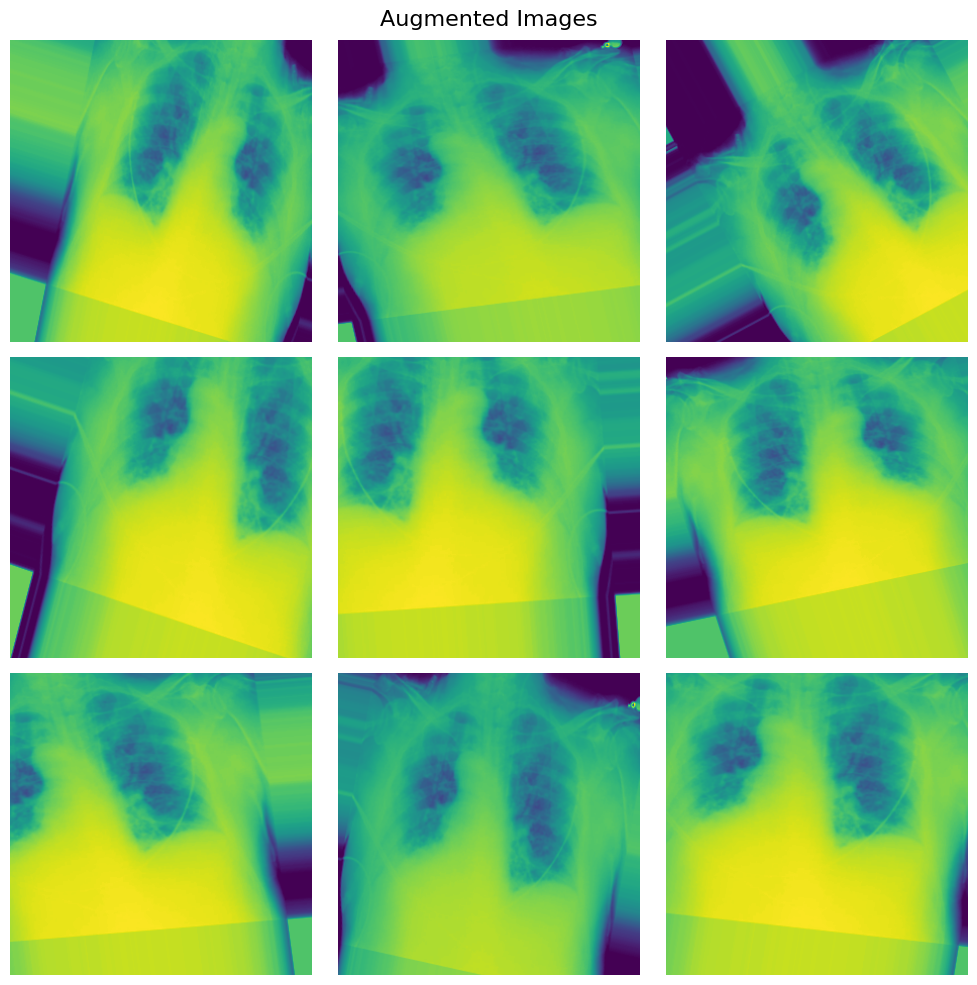

In [6]:
# Initialize the ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,       # Rotate the image by up to 30 degrees
    width_shift_range=0.2,   # Horizontally shift the image by up to 20%
    height_shift_range=0.2,  # Vertically shift the image by up to 20%
    shear_range=0.2,         # Shear transformation
    zoom_range=0.2,          # Zoom in or out by up to 20%
    horizontal_flip=True,    # Flip the image horizontally
    fill_mode='nearest'      # Fill missing pixels with the nearest pixel value
)

# Choose a sample category and image for augmentation visualization
sample_category = categories[0]  # Using the first category
sample_image_folder = os.path.join(data_dir, sample_category, 'images')

# Load a sample image
if os.path.exists(sample_image_folder) and os.listdir(sample_image_folder):
    sample_image_path = os.path.join(sample_image_folder, os.listdir(sample_image_folder)[0])
    img = Image.open(sample_image_path)
    img_array = np.array(img)  # Convert the image to a numpy array
else:
    print(f"No images found in the 'images' folder of {sample_category}")

# Check if the image is grayscale or RGB
if len(img_array.shape) == 2:  # Grayscale image
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension

# Reshape the image to (1, height, width, channels) for the generator
img_array = img_array.reshape((1,) + img_array.shape)

# Generate and visualize augmented images
plt.figure(figsize=(10, 10))
for i, batch in enumerate(datagen.flow(img_array, batch_size=1)):
    # Display augmented images
    plt.subplot(3, 3, i + 1)  # 3x3 grid for augmented images
    aug_img = batch[0].astype('uint8')
    plt.imshow(aug_img.squeeze())  # Use .squeeze() to handle grayscale images
    plt.axis('off')
    
    # Stop after 9 images
    if i == 8:
        break

plt.suptitle('Augmented Images', fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
# Create an instance of ImageDataGenerator for test data with rescaling
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Path to the test data directory (assumes similar structure as train data)
test_dir = data_dir  # Use the same base directory since test images are within category folders

# Create the test data generator
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(300, 300),  # Resize images to 300x300 (adjust as needed)
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' if there are multiple categories
    shuffle=False,  # No shuffling for the test set to maintain order
    classes=['covid', 'lung_opacity', 'normal', 'viral_pneumonia'],  # Specify category names
    subset=None  # No subset for the test generator
)

# Check the number of samples in the test generator
print(f"Number of test images found: {test_generator.samples}")

Found 39640 images belonging to 4 classes.
Number of test images found: 39640


Found 33866 images belonging to 4 classes.
Found 8464 images belonging to 4 classes.


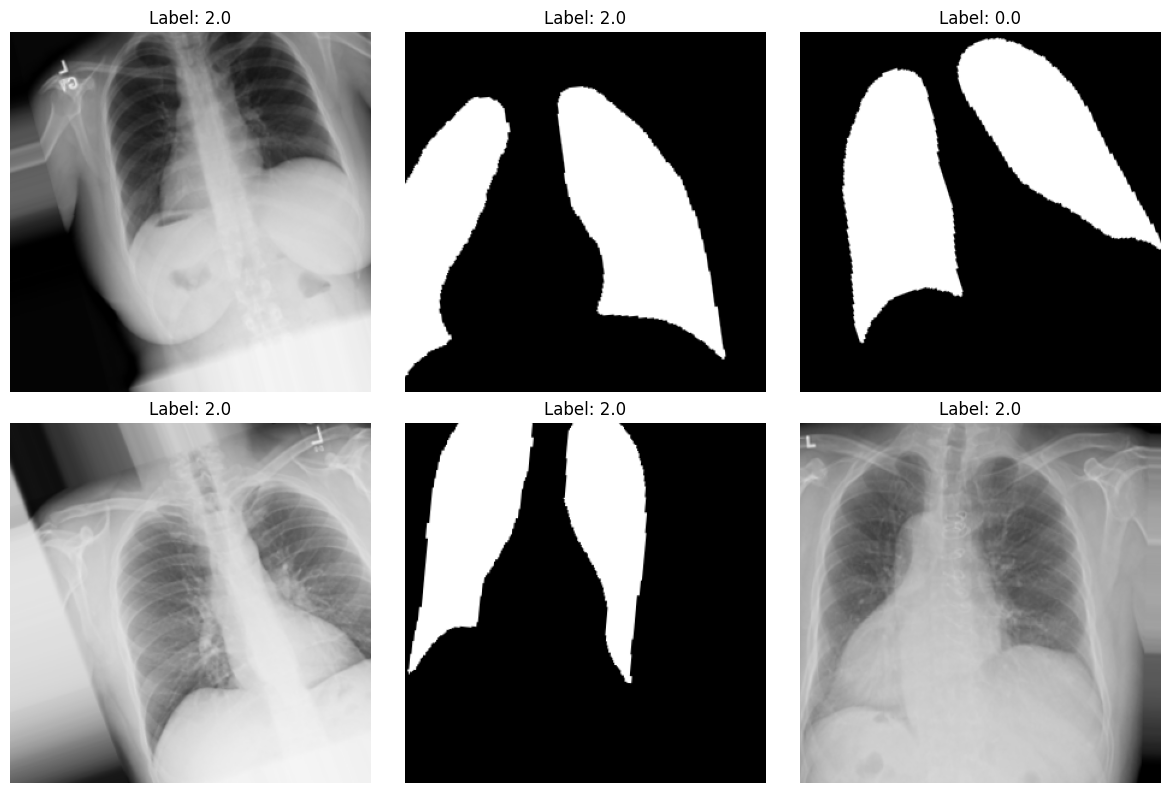

In [8]:
# Define the base directory where the dataset is located
data_dir = r'C:\Users\SHRAVYA\Downloads\archive (12)\COVID-19_Radiography_Dataset'

# Use the folders directly as the dataset
# We will assume you are using all data for training without splitting
data_generator = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.15,  # Shear transformation
    zoom_range=0.15,  # Zoom in/out
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest',  # Fill missing pixels after transformation
    validation_split=0.2  # Split 80% training and 20% validation
)

# Use flow_from_directory to load images
train_generator = data_generator.flow_from_directory(
    directory=data_dir,
    target_size=(300, 300),  # Resize images to 300x300
    batch_size=32,  # Number of images per batch
    class_mode='binary',  # Use 'categorical' if you have more than 2 categories
    subset='training'  # Use the 'training' split
)

validation_generator = data_generator.flow_from_directory(
    directory=data_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Use the 'validation' split
)

# Check the first batch of images from the training generator
sample_images, sample_labels = next(train_generator)

# Display a few sample images from the training generator
plt.figure(figsize=(12, 8))
for i in range(6):  # Display 6 images
    plt.subplot(2, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Label: {sample_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
# Custom CNN Model with GAP, Dropout, and Batch Normalization
def create_custom_cnn(input_shape=(300, 300, 3)):
    model = Sequential([
        Input(shape=input_shape),
        
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.2),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.3),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.4),
        
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.5),
        
        GlobalAveragePooling2D(),
        Dropout(0.5),
        
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )
    
    return model

# Create the custom CNN model
custom_cnn_model = create_custom_cnn()
custom_cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 300, 300, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 300, 300, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 150, 150, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 150, 150, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 150, 150, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,5

 Total params: 524,481 (2.00 MB)

 Trainable params: 522,497 (1.99 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [10]:
# Pre-trained VGG16 Model with Fine-Tuning
def create_vgg16_model(input_shape=(300, 300, 3)):
    base_model = VGG16(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )
    
    # Unfreeze some top layers for fine-tuning
    for layer in base_model.layers[-4:]:  # Unfreeze last 4 layers
        layer.trainable = True
        
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.00001),
        metrics=['accuracy']
    )
    
    return model

# Create the VGG16 model
vgg16_model = create_vgg16_model()
vgg16_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ ?                           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)